In [1]:
import torch
from src.model_utils import load_model, tokenize_sentence, word2idx, load_word2vec_format, predict_single_text_DE
import torch

In [2]:
model = load_model('IMDB_DE_best_model')

w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embedding = torch.nn.Embedding.from_pretrained(embedding_weights)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = "I love this movie. It's the best movie I've ever seen!"

print(predict_single_text_DE(text, model, device=device, model_type='IMDB', embedding=embedding))

1


In [4]:
def smoothgrad(input_text: str,
               model: torch.nn.Module,
               embedding: torch.nn.Embedding,
               num_samples: int = 50,
               noise_level: float = 0.1,
               device: str = 'cpu') -> torch.Tensor:
    """
    Calculate SmoothGrad for a given input text.

    Args:
        input_text (str): The input text for which to calculate SmoothGrad.
        model (torch.nn.Module): The model used for prediction.
        embedding (torch.nn.Embedding): The embedding layer to be applied to the input texts.
        num_samples (int): Number of noise samples.
        noise_level (float): Level of noise to add to input.
        device (str): The device to run the model on.

    Returns:
        torch.Tensor: SmoothGrad attributions for each token in the input text.
    """

    # Tokenize input 
    tokenized_input = tokenize_sentence(input_text)

    # Convert tokens to indices
    input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)
    
    # Create baseline input
    baseline_indices = torch.zeros_like(input_indices).to(device)

    # Calculate difference between input and baseline embeddings
    input_embedding = embedding(input_indices)
    baseline_embedding = embedding(baseline_indices)
    diff = input_embedding - baseline_embedding

    # Generate perturbed inputs with noise
    smoothgrad_inputs = []
    for _ in range(num_samples):
        noise = torch.randn_like(input_embedding) * noise_level
        perturbed_input = input_embedding + noise
        smoothgrad_inputs.append(perturbed_input)
    
    smoothgrad_inputs = torch.cat(smoothgrad_inputs, dim=0)

    # Calculate model outputs for perturbed inputs
    smoothgrad_inputs.requires_grad_(True)
    model.to(device)
    model.eval()
    outputs = model(smoothgrad_inputs, torch.tensor([len(tokenized_input)] * num_samples).to(device))

    # Choose the output element to compute gradients with respect to

    # Calculate gradients for the chosen output element
    gradients = torch.autograd.grad(outputs=outputs.sum(), inputs=smoothgrad_inputs)[0]

    # Calculate SmoothGrad (average gradients over noise samples)
    smoothgrad_attributions = torch.mean(gradients, dim=0)

    return smoothgrad_attributions



In [16]:
import torch
import torch.nn as nn

# Define a sample input text
input_text =  "I love this movie. It's the best movie I've ever seen!"

# Calculate SmoothGrad attributions
smoothgrad_attributions = smoothgrad(input_text, model, embedding, num_samples=50, noise_level=0.1, device='cpu')

# Normalize attributions to [0, 1]
smoothgrad_attributions = torch.abs(smoothgrad_attributions) / torch.max(torch.abs(smoothgrad_attributions))

# Convert input text to tokens
tokenized_input = tokenize_sentence(input_text)

# Sort tokens based on their SmoothGrad attributions (from highest to lowest)
sorted_indices = torch.argsort(smoothgrad_attributions, descending=True)

tokens = []
attributtions = []

# Print tokens along with their SmoothGrad attributions
for i in range(len(tokenized_input)):
    token = tokenized_input[i]
    tokens.append(token)
    token_sg = smoothgrad_attributions[i]
    attributtions.append(token_sg.mean().item())
    print(f"Token: {token} - SmoothGrad Attribution: {token_sg}")

Token: I - SmoothGrad Attribution: tensor([0.0242, 0.0090, 0.0416, 0.0127, 0.0605, 0.0601, 0.0083, 0.0173, 0.0067,
        0.0263, 0.0421, 0.0134, 0.1026, 0.0550, 0.0196, 0.0031, 0.0548, 0.0653,
        0.0326, 0.0520, 0.0134, 0.0190, 0.0307, 0.0344, 0.0441, 0.0848, 0.0536,
        0.0173, 0.0774, 0.0165, 0.0077, 0.0033, 0.0353, 0.1405, 0.0157, 0.0412,
        0.0245, 0.1206, 0.0154, 0.0476, 0.0163, 0.0316, 0.0934, 0.1260, 0.0089,
        0.0919, 0.0051, 0.0343, 0.0843, 0.0343, 0.0884, 0.0497, 0.0263, 0.0323,
        0.0600, 0.0308, 0.0151, 0.0231, 0.0379, 0.0373, 0.0591, 0.0535, 0.0579,
        0.0257, 0.0548, 0.1083, 0.0150, 0.0129, 0.0317, 0.0333, 0.0041, 0.0050,
        0.0285, 0.0190, 0.0561, 0.0465, 0.0329, 0.0259, 0.0125, 0.0181, 0.0025,
        0.0063, 0.0662, 0.0071, 0.0430, 0.0044, 0.0787, 0.0493, 0.0522, 0.0302,
        0.0093, 0.0087, 0.0082, 0.0281, 0.0350, 0.0302, 0.0106, 0.0106, 0.0214,
        0.1515, 0.1114, 0.0129, 0.0274, 0.0655, 0.0278, 0.0270, 0.0395, 0.0019,
     

C:\Users\cptad\AppData\Local\Temp\ipykernel_13140\494806234.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)


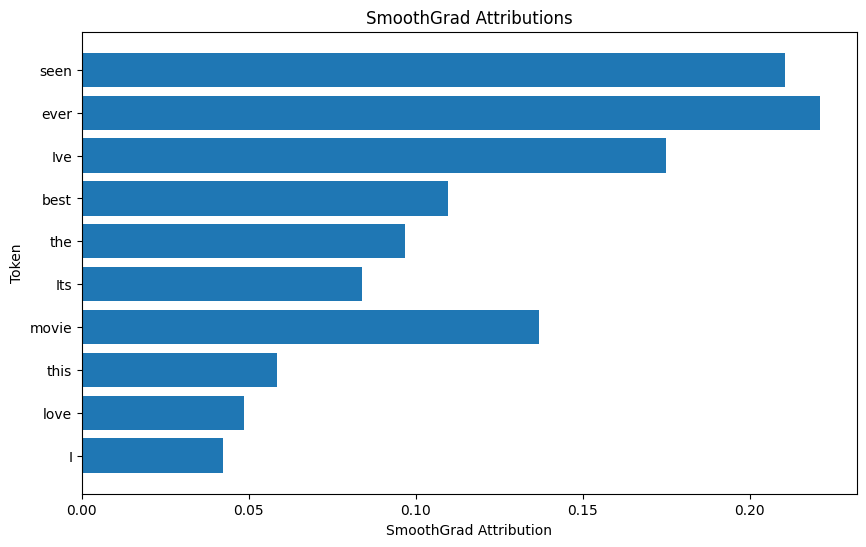

In [18]:
import matplotlib.pyplot as plt

# Plot absolute integrated gradients
plt.figure(figsize=(10, 6))
plt.barh(tokens, attributtions)
plt.xlabel('SmoothGrad Attribution')
plt.ylabel('Token')
plt.title('SmoothGrad Attributions')
plt.show()
